In [ ]:
import pandas as pd
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity


## Reading the dataset

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/Raswanth8/ml-notebooks/main/csv/MoviesOnStreamingPlatforms_updated.csv")

In [ ]:
df.head()

,Unnamed: 0,Unnamed: 0.1,ID,Title,Year,Age,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Type,Directors,Genres,Country,Language,Runtime
0,0,0,1,The Irishman,2019,18+,7.8/10,98/100,Yes,No,No,No,0,Martin Scorsese,"Biography,Crime,Drama",United States,"English,Italian,Latin,Spanish,German",209.0
1,1,1,2,Dangal,2016,7+,8.4/10,97/100,Yes,No,No,No,0,Nitesh Tiwari,"Action,Biography,Drama,Sport","India,United States,United Kingdom,Australia,K...","Hindi,English",161.0
2,2,2,3,David Attenborough: A Life on Our Planet,2020,7+,9.0/10,95/100,Yes,No,No,No,0,"Alastair Fothergill,Jonathan Hughes,Keith Scholey","Documentary,Biography",United Kingdom,English,83.0
3,3,3,4,Lagaan: Once Upon a Time in India,2001,7+,8.1/10,94/100,Yes,No,No,No,0,Ashutosh Gowariker,"Drama,Musical,Sport","India,United Kingdom","Hindi,English",224.0
4,4,4,5,Roma,2018,18+,7.7/10,94/100,Yes,No,No,No,0,NaN,"Action,Drama,History,Romance,War","United Kingdom,United States",English,52.0


# Preprocessing

### Removing unwanted columns

In [ ]:
df.drop(df.columns[0:2],inplace=True,axis=1)
df

,ID,Title,Year,Age,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Type,Directors,Genres,Country,Language,Runtime
0,1,The Irishman,2019,18+,7.8/10,98/100,Yes,No,No,No,0,Martin Scorsese,"Biography,Crime,Drama",United States,"English,Italian,Latin,Spanish,German",209.0
1,2,Dangal,2016,7+,8.4/10,97/100,Yes,No,No,No,0,Nitesh Tiwari,"Action,Biography,Drama,Sport","India,United States,United Kingdom,Australia,K...","Hindi,English",161.0
2,3,David Attenborough: A Life on Our Planet,2020,7+,9.0/10,95/100,Yes,No,No,No,0,"Alastair Fothergill,Jonathan Hughes,Keith Scholey","Documentary,Biography",United Kingdom,English,83.0
3,4,Lagaan: Once Upon a Time in India,2001,7+,8.1/10,94/100,Yes,No,No,No,0,Ashutosh Gowariker,"Drama,Musical,Sport","India,United Kingdom","Hindi,English",224.0
4,5,Roma,2018,18+,7.7/10,94/100,Yes,No,No,No,0,NaN,"Action,Drama,History,Romance,War","United Kingdom,United States",English,52.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9510,9511,Most Wanted Sharks,2020,NaN,NaN,14/100,No,No,No,Yes,0,NaN,"Crime,Reality-TV",United States,"Greek,English",NaN
9511,9512,Doc McStuffins: The Doc Is In,2020,NaN,NaN,13/100,No,No,No,Yes,0,Chris Anthony Hamilton,Animation,United States,English,23.0
9512,9513,Ultimate Viking Sword,2019,NaN,NaN,13/100,No,No,No,Yes,0,NaN,NaN,United States,NaN,NaN
9513,9514,Hunt for the Abominable Snowman,2011,NaN,NaN,10/100,No,No,No,Yes,0,Dan Oliver,"Drama,History",NaN,NaN,NaN


In [ ]:
df.drop_duplicates(keep="first",inplace=True)

In [ ]:
df.shape

(9515, 16)

In [ ]:
#df.set_index("ID",inplace=True)
df.head()

,ID,Title,Year,Age,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Type,Directors,Genres,Country,Language,Runtime
0,1,The Irishman,2019,18+,7.8/10,98/100,Yes,No,No,No,0,Martin Scorsese,"Biography,Crime,Drama",United States,"English,Italian,Latin,Spanish,German",209.0
1,2,Dangal,2016,7+,8.4/10,97/100,Yes,No,No,No,0,Nitesh Tiwari,"Action,Biography,Drama,Sport","India,United States,United Kingdom,Australia,K...","Hindi,English",161.0
2,3,David Attenborough: A Life on Our Planet,2020,7+,9.0/10,95/100,Yes,No,No,No,0,"Alastair Fothergill,Jonathan Hughes,Keith Scholey","Documentary,Biography",United Kingdom,English,83.0
3,4,Lagaan: Once Upon a Time in India,2001,7+,8.1/10,94/100,Yes,No,No,No,0,Ashutosh Gowariker,"Drama,Musical,Sport","India,United Kingdom","Hindi,English",224.0
4,5,Roma,2018,18+,7.7/10,94/100,Yes,No,No,No,0,NaN,"Action,Drama,History,Romance,War","United Kingdom,United States",English,52.0


### Handling missing values

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9515 entries, 0 to 9514
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               9515 non-null   int64  
 1   Title            9515 non-null   object 
 2   Year             9515 non-null   int64  
 3   Age              5338 non-null   object 
 4   IMDb             9309 non-null   object 
 5   Rotten Tomatoes  9508 non-null   object 
 6   Netflix          9515 non-null   object 
 7   Hulu             9515 non-null   object 
 8   Prime Video      9515 non-null   object 
 9   Disney+          9515 non-null   object 
 10  Type             9515 non-null   int64  
 11  Directors        9104 non-null   object 
 12  Genres           9399 non-null   object 
 13  Country          9261 non-null   object 
 14  Language         9202 non-null   object 
 15  Runtime          9196 non-null   float64
dtypes: float64(1), int64(3), object(12)
memory usage: 1.2+ MB


In [ ]:
df.isna().sum()

ID                    0
Title                 0
Year                  0
Age                4177
IMDb                206
Rotten Tomatoes       7
Netflix               0
Hulu                  0
Prime Video           0
Disney+               0
Type                  0
Directors           411
Genres              116
Country             254
Language            313
Runtime             319
dtype: int64

##### Removing "Type" feature as it is of less importance

In [ ]:
df.drop(["Type","Age"],inplace=True,axis=1)

In [ ]:
# Missing values in "Directors" cannot be imputed. Hence drop such instances
df1 = df[df['Directors'].notna()]
df1.isna().sum()

ID                   0
Title                0
Year                 0
IMDb               119
Rotten Tomatoes      2
Netflix              0
Hulu                 0
Prime Video          0
Disney+              0
Directors            0
Genres              11
Country            102
Language           158
Runtime            145
dtype: int64

For building a model, we must remove 'commas' by replacing them with 'spaces'

In [ ]:
df1.Country = df1.Country.str.replace(',', ' ')
df1.Directors = df1.Directors.str.replace(',', ' ')
df1.Language = df1.Language.str.replace(',', ' ')
df1.Genres = df1.Genres.str.replace(',', ' ')
df1

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,ID,Title,Year,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Directors,Genres,Country,Language,Runtime
0,1,The Irishman,2019,7.8/10,98/100,Yes,No,No,No,Martin Scorsese,Biography Crime Drama,United States,English Italian Latin Spanish German,209.0
1,2,Dangal,2016,8.4/10,97/100,Yes,No,No,No,Nitesh Tiwari,Action Biography Drama Sport,India United States United Kingdom Australia K...,Hindi English,161.0
2,3,David Attenborough: A Life on Our Planet,2020,9.0/10,95/100,Yes,No,No,No,Alastair Fothergill Jonathan Hughes Keith Scholey,Documentary Biography,United Kingdom,English,83.0
3,4,Lagaan: Once Upon a Time in India,2001,8.1/10,94/100,Yes,No,No,No,Ashutosh Gowariker,Drama Musical Sport,India United Kingdom,Hindi English,224.0
5,6,To All the Boys I've Loved Before,2018,7.1/10,94/100,Yes,No,No,No,Susan Johnson,Comedy Drama Romance,United States,English,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9508,9509,What the Shark?,2020,NaN,14/100,No,No,No,Yes,Jenn Barlow,Reality-TV,NaN,NaN,NaN
9509,9510,Built for Mars: The Perseverance Rover,2021,NaN,14/100,No,No,No,Yes,Mark Davis,NaN,United States,NaN,NaN
9511,9512,Doc McStuffins: The Doc Is In,2020,NaN,13/100,No,No,No,Yes,Chris Anthony Hamilton,Animation,United States,English,23.0
9513,9514,Hunt for the Abominable Snowman,2011,NaN,10/100,No,No,No,Yes,Dan Oliver,Drama History,NaN,NaN,NaN


We replace null values to Blank Strings so as Count Vectorizer can still work on it considering empty strings

In [ ]:
df1.fillna("",inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
df1

,ID,Title,Year,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Directors,Genres,Country,Language,Runtime
0,1,The Irishman,2019,7.8/10,98/100,Yes,No,No,No,Martin Scorsese,Biography Crime Drama,United States,English Italian Latin Spanish German,209
1,2,Dangal,2016,8.4/10,97/100,Yes,No,No,No,Nitesh Tiwari,Action Biography Drama Sport,India United States United Kingdom Australia K...,Hindi English,161
2,3,David Attenborough: A Life on Our Planet,2020,9.0/10,95/100,Yes,No,No,No,Alastair Fothergill Jonathan Hughes Keith Scholey,Documentary Biography,United Kingdom,English,83
3,4,Lagaan: Once Upon a Time in India,2001,8.1/10,94/100,Yes,No,No,No,Ashutosh Gowariker,Drama Musical Sport,India United Kingdom,Hindi English,224
5,6,To All the Boys I've Loved Before,2018,7.1/10,94/100,Yes,No,No,No,Susan Johnson,Comedy Drama Romance,United States,English,99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9508,9509,What the Shark?,2020,,14/100,No,No,No,Yes,Jenn Barlow,Reality-TV,,,
9509,9510,Built for Mars: The Perseverance Rover,2021,,14/100,No,No,No,Yes,Mark Davis,,United States,,
9511,9512,Doc McStuffins: The Doc Is In,2020,,13/100,No,No,No,Yes,Chris Anthony Hamilton,Animation,United States,English,23
9513,9514,Hunt for the Abominable Snowman,2011,,10/100,No,No,No,Yes,Dan Oliver,Drama History,,,


In columns "IMDb" and "Rotten Tomatoes" removing the out of scale and normalizing scale to out of 10

In [ ]:
# For IMDb
df1['IMDb'] = df1['IMDb'].str.replace("/10", "")

#Rotten Tomatoes
df1['Rotten Tomatoes'] = df1['Rotten Tomatoes'].str.replace("/100", "")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9104 entries, 0 to 9514
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               9104 non-null   int64 
 1   Title            9104 non-null   object
 2   Year             9104 non-null   int64 
 3   IMDb             9104 non-null   object
 4   Rotten Tomatoes  9104 non-null   object
 5   Netflix          9104 non-null   object
 6   Hulu             9104 non-null   object
 7   Prime Video      9104 non-null   object
 8   Disney+          9104 non-null   object
 9   Directors        9104 non-null   object
 10  Genres           9104 non-null   object
 11  Country          9104 non-null   object
 12  Language         9104 non-null   object
 13  Runtime          9104 non-null   object
dtypes: int64(2), object(12)
memory usage: 1.0+ MB


In [ ]:
df1["Combined_columns"]=df1["Title"]+" "+df1.Directors+" "+df1.Genres+" "+df1.Country+" "+df1.Language

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df1

,ID,Title,Year,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Directors,Genres,Country,Language,Runtime,Combined_columns
0,1,The Irishman,2019,7.8,98,Yes,No,No,No,Martin Scorsese,Biography Crime Drama,United States,English Italian Latin Spanish German,209,The Irishman Martin Scorsese Biography Crime D...
1,2,Dangal,2016,8.4,97,Yes,No,No,No,Nitesh Tiwari,Action Biography Drama Sport,India United States United Kingdom Australia K...,Hindi English,161,Dangal Nitesh Tiwari Action Biography Drama Sp...
2,3,David Attenborough: A Life on Our Planet,2020,9.0,95,Yes,No,No,No,Alastair Fothergill Jonathan Hughes Keith Scholey,Documentary Biography,United Kingdom,English,83,David Attenborough: A Life on Our Planet Alast...
3,4,Lagaan: Once Upon a Time in India,2001,8.1,94,Yes,No,No,No,Ashutosh Gowariker,Drama Musical Sport,India United Kingdom,Hindi English,224,Lagaan: Once Upon a Time in India Ashutosh Gow...
5,6,To All the Boys I've Loved Before,2018,7.1,94,Yes,No,No,No,Susan Johnson,Comedy Drama Romance,United States,English,99,To All the Boys I've Loved Before Susan Johnso...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9508,9509,What the Shark?,2020,,14,No,No,No,Yes,Jenn Barlow,Reality-TV,,,,What the Shark? Jenn Barlow Reality-TV
9509,9510,Built for Mars: The Perseverance Rover,2021,,14,No,No,No,Yes,Mark Davis,,United States,,,Built for Mars: The Perseverance Rover Mark Da...
9511,9512,Doc McStuffins: The Doc Is In,2020,,13,No,No,No,Yes,Chris Anthony Hamilton,Animation,United States,English,23,Doc McStuffins: The Doc Is In Chris Anthony Ha...
9513,9514,Hunt for the Abominable Snowman,2011,,10,No,No,No,Yes,Dan Oliver,Drama History,,,,Hunt for the Abominable Snowman Dan Oliver Dra...


## Recommendation System

In [ ]:
##Step 4: Create count matrix from this new combined column
cv = CountVectorizer()

In [ ]:
count_matrix = cv.fit_transform(df1["Combined_columns"])


In [ ]:
count_matrix

<9104x16259 sparse matrix of type '<class 'numpy.int64'>'
	with 102854 stored elements in Compressed Sparse Row format>

In [ ]:
df1.reset_index(inplace=True)

In [ ]:
df1.drop(["index","ID"],axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df1.reset_index(inplace=True) #TWICE

In [ ]:
df1

,index,Title,Year,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Directors,Genres,Country,Language,Runtime,Combined_columns
0,0,The Irishman,2019,7.8,98,Yes,No,No,No,Martin Scorsese,Biography Crime Drama,United States,English Italian Latin Spanish German,209,The Irishman Martin Scorsese Biography Crime D...
1,1,Dangal,2016,8.4,97,Yes,No,No,No,Nitesh Tiwari,Action Biography Drama Sport,India United States United Kingdom Australia K...,Hindi English,161,Dangal Nitesh Tiwari Action Biography Drama Sp...
2,2,David Attenborough: A Life on Our Planet,2020,9.0,95,Yes,No,No,No,Alastair Fothergill Jonathan Hughes Keith Scholey,Documentary Biography,United Kingdom,English,83,David Attenborough: A Life on Our Planet Alast...
3,3,Lagaan: Once Upon a Time in India,2001,8.1,94,Yes,No,No,No,Ashutosh Gowariker,Drama Musical Sport,India United Kingdom,Hindi English,224,Lagaan: Once Upon a Time in India Ashutosh Gow...
4,4,To All the Boys I've Loved Before,2018,7.1,94,Yes,No,No,No,Susan Johnson,Comedy Drama Romance,United States,English,99,To All the Boys I've Loved Before Susan Johnso...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9099,9099,What the Shark?,2020,,14,No,No,No,Yes,Jenn Barlow,Reality-TV,,,,What the Shark? Jenn Barlow Reality-TV
9100,9100,Built for Mars: The Perseverance Rover,2021,,14,No,No,No,Yes,Mark Davis,,United States,,,Built for Mars: The Perseverance Rover Mark Da...
9101,9101,Doc McStuffins: The Doc Is In,2020,,13,No,No,No,Yes,Chris Anthony Hamilton,Animation,United States,English,23,Doc McStuffins: The Doc Is In Chris Anthony Ha...
9102,9102,Hunt for the Abominable Snowman,2011,,10,No,No,No,Yes,Dan Oliver,Drama History,,,,Hunt for the Abominable Snowman Dan Oliver Dra...


In [ ]:
df1.drop_duplicates()

,index,Title,Year,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Directors,Genres,Country,Language,Runtime,Combined_columns
0,0,The Irishman,2019,7.8,98,Yes,No,No,No,Martin Scorsese,Biography Crime Drama,United States,English Italian Latin Spanish German,209,The Irishman Martin Scorsese Biography Crime D...
1,1,Dangal,2016,8.4,97,Yes,No,No,No,Nitesh Tiwari,Action Biography Drama Sport,India United States United Kingdom Australia K...,Hindi English,161,Dangal Nitesh Tiwari Action Biography Drama Sp...
2,2,David Attenborough: A Life on Our Planet,2020,9.0,95,Yes,No,No,No,Alastair Fothergill Jonathan Hughes Keith Scholey,Documentary Biography,United Kingdom,English,83,David Attenborough: A Life on Our Planet Alast...
3,3,Lagaan: Once Upon a Time in India,2001,8.1,94,Yes,No,No,No,Ashutosh Gowariker,Drama Musical Sport,India United Kingdom,Hindi English,224,Lagaan: Once Upon a Time in India Ashutosh Gow...
4,4,To All the Boys I've Loved Before,2018,7.1,94,Yes,No,No,No,Susan Johnson,Comedy Drama Romance,United States,English,99,To All the Boys I've Loved Before Susan Johnso...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9099,9099,What the Shark?,2020,,14,No,No,No,Yes,Jenn Barlow,Reality-TV,,,,What the Shark? Jenn Barlow Reality-TV
9100,9100,Built for Mars: The Perseverance Rover,2021,,14,No,No,No,Yes,Mark Davis,,United States,,,Built for Mars: The Perseverance Rover Mark Da...
9101,9101,Doc McStuffins: The Doc Is In,2020,,13,No,No,No,Yes,Chris Anthony Hamilton,Animation,United States,English,23,Doc McStuffins: The Doc Is In Chris Anthony Ha...
9102,9102,Hunt for the Abominable Snowman,2011,,10,No,No,No,Yes,Dan Oliver,Drama History,,,,Hunt for the Abominable Snowman Dan Oliver Dra...


In [ ]:
def get_title_from_index(index):
	return df1.iloc[index]["Title"]

def get_index_from_title(title):
	return pd.DataFrame(df1.loc[df1['Title'] == title])["index"].values[0]

In [ ]:
cosine_sim = cosine_similarity(count_matrix) 
movie_user_likes=input("Enter movie name: ")
movie_index = get_index_from_title(movie_user_likes)
print(movie_index)
similar_movies =  list(enumerate(cosine_sim[movie_index]))
sorted_similar_movies = sorted(similar_movies,key=lambda x:x[1],reverse=True)

Enter movie name: Dangal
1


In [ ]:
i=0
print("RECOMMENDED MOVIES")
for element in sorted_similar_movies:
    print(get_title_from_index(element[0]),str(round(element[1]*100,6))+"%")
    i=i+1
    if i>50:
        break

RECOMMENDED MOVIES
Dangal 100.0%
Hotel Mumbai 61.558701%
Mary Magdalene 59.234888%
Ammonite 59.234888%
The Program 59.234888%
Rush 57.894737%
Knowing 57.353933%
Tubelight 57.353933%
Sultan 57.265629%
Steve Jobs 57.265629%
Rangoon 57.265629%
Robert the Bruce 55.641488%
Saving Mr. Banks 55.641488%
Counterpunch 55.337157%
Blackbird 55.337157%
Philomena 55.182541%
Bully 55.182541%
J.T. LeRoy 55.182541%
Soldier 55.182541%
Judy 55.182541%
Seberg 55.182541%
Cromwell 55.182541%
The Sundowners 55.182541%
Fighting With My Family 54.073807%
Sold 53.530338%
Gracie 53.530338%
Safety 53.530338%
Legend 53.311399%
Get on Up 53.311399%
Close 53.311399%
Big Miracle 53.311399%
Boss 53.311399%
12 Years a Slave 53.311399%
127 Hours 53.311399%
Rocketman 53.311399%
The Soloist 53.311399%
The Elephant Man 53.311399%
The Hunting Party 53.311399%
Enigma 53.311399%
Snow White 53.311399%
The Straight Story 53.311399%
Willow 53.311399%
Skater Girl 52.981294%
Concrete Cowboy 52.981294%
Eliminators 52.981294%
Unhing

### Exploratory Data Analysis

In [ ]:
netflix = df['Netflix']
pvideo = df['Prime Video']
disney = df['Disney+']
hulu = df['Hulu']

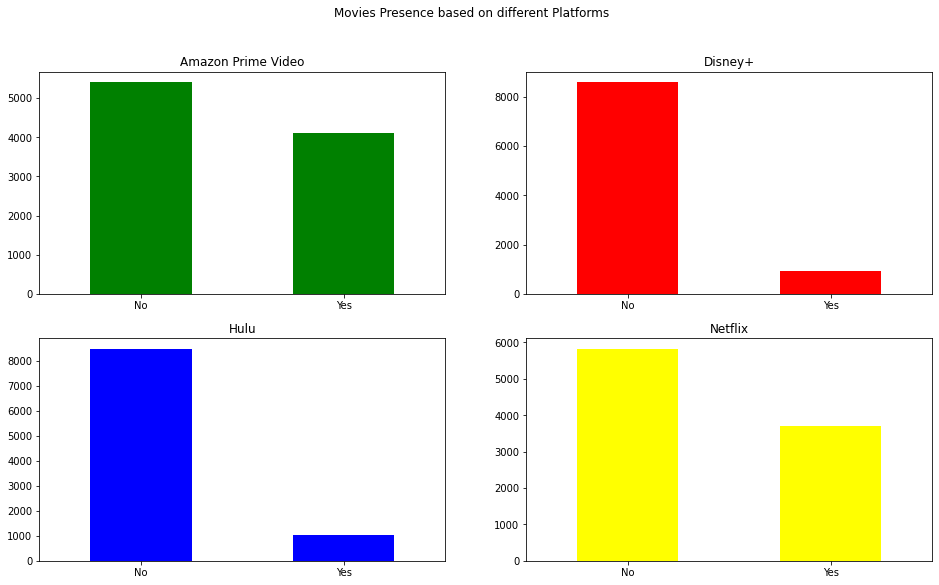

In [ ]:
plt.subplot(221)
pvideo.value_counts().plot(kind='bar', title='Amazon Prime Video', figsize=(16,9),color='green')
plt.xticks(rotation=0)
plt.subplot(222)
disney.value_counts().plot(kind='bar', title='Disney+',color='red')
plt.xticks(rotation=0)
plt.subplot(223)
hulu.value_counts().plot(kind='bar', title='Hulu',color='blue')
plt.xticks(rotation=0)
plt.subplot(224)
netflix.value_counts().plot(kind='bar', title='Netflix',color='yellow')
plt.xticks(rotation=0)
plt.suptitle("Movies Presence based on different Platforms")
plt.show()

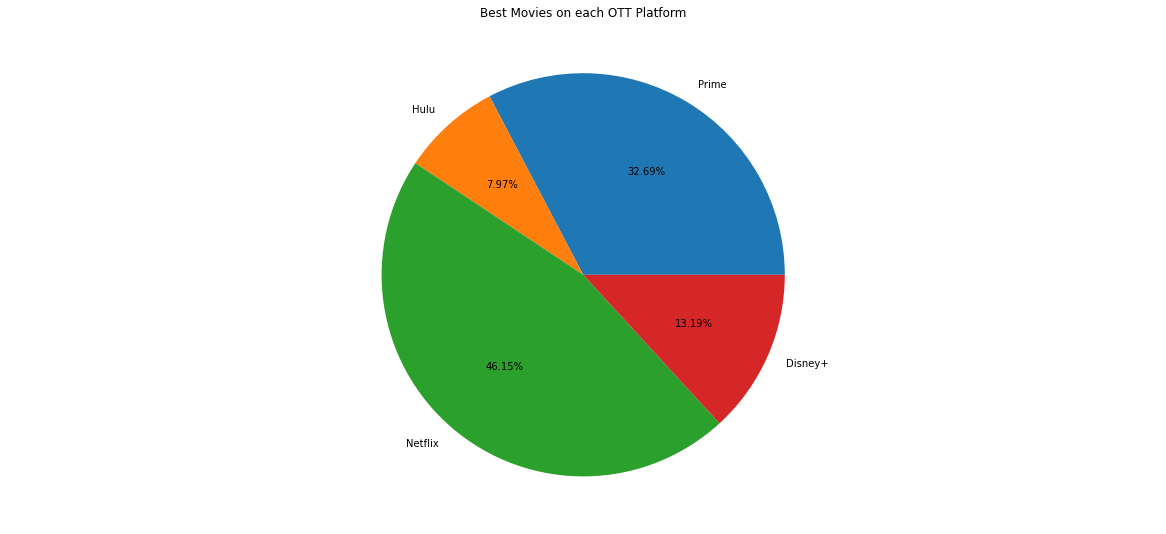

In [ ]:
df_netflix=df[df["Netflix"]=='Yes']
df_hulu=df[df["Hulu"]=='Yes']
df_prime=df[df["Prime Video"]=='Yes']
df_disney=df[df["Disney+"]=='Yes']

disney8=df_disney[df_disney["IMDb"]>='8']
hulu8=df_hulu[df_hulu["IMDb"]>='8']
netflix8=df_netflix[df_netflix["IMDb"]>='8']
prime8=df_prime[df_prime["IMDb"]>='8']

count_disney8=len(disney8)
count_hulu8=len(hulu8)
count_netflix8=len(netflix8)
count_prime8=len(prime8)

fig = plt.figure(figsize=(16,7))
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
names=["Prime", "Hulu", "Netflix", "Disney+"]
values=[count_prime8, count_hulu8, count_netflix8, count_disney8]
fig = ax.pie(values,labels = names,autopct='%1.2f%%' )
plt.title("Best Movies on each OTT Platform")
plt.show()

In [ ]:
def split_mulcol(x):
    res = x.to_frame()
    opt = []
    
    for i, j  in x[x.notnull()].iteritems():
        
        for k in j.split(','):
            
            if not k in res.columns:
                opt.append(k)
                res[k] = False
            
            res.at[i, k] = True
    
    return res[opt]
genres = split_mulcol(df1["Genres"])
genres = genres.sum().sort_values(ascending=False).reset_index()
genres = pd.DataFrame(genres.values, columns=['Genre',"No. of Movies"])
genres = genres[:20]

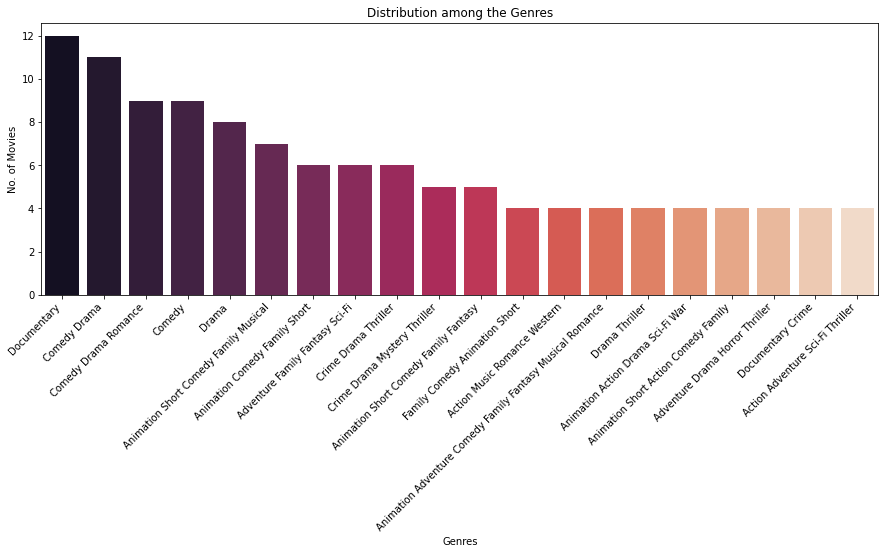

In [ ]:
plt.figure(figsize = (15,5))
ax = sns.barplot(x=genres["Genre"], y= genres["No. of Movies"], data=genres , palette = "rocket")
plt.title ("Distribution among the Genres")
plt.xticks(rotation = 45, ha = 'right')
plt.xlabel("Genres")
plt.ylabel("No. of Movies")
plt.show()

#### Applying Regression techniques to compute Runtime

In [ ]:
df.head()

,ID,Title,Year,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Directors,Genres,Country,Language,Runtime
0,1,The Irishman,2019,7.8/10,98/100,Yes,No,No,No,Martin Scorsese,"Biography,Crime,Drama",United States,"English,Italian,Latin,Spanish,German",209.0
1,2,Dangal,2016,8.4/10,97/100,Yes,No,No,No,Nitesh Tiwari,"Action,Biography,Drama,Sport","India,United States,United Kingdom,Australia,K...","Hindi,English",161.0
2,3,David Attenborough: A Life on Our Planet,2020,9.0/10,95/100,Yes,No,No,No,"Alastair Fothergill,Jonathan Hughes,Keith Scholey","Documentary,Biography",United Kingdom,English,83.0
3,4,Lagaan: Once Upon a Time in India,2001,8.1/10,94/100,Yes,No,No,No,Ashutosh Gowariker,"Drama,Musical,Sport","India,United Kingdom","Hindi,English",224.0
4,5,Roma,2018,7.7/10,94/100,Yes,No,No,No,NaN,"Action,Drama,History,Romance,War","United Kingdom,United States",English,52.0


In [ ]:
# Dropping "Title","Directors" --> keeping ID to track movies
df1 = df.drop(["Title","Directors","ID"],axis=1)
df1.head()

,Year,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Genres,Country,Language,Runtime
0,2019,7.8/10,98/100,Yes,No,No,No,"Biography,Crime,Drama",United States,"English,Italian,Latin,Spanish,German",209.0
1,2016,8.4/10,97/100,Yes,No,No,No,"Action,Biography,Drama,Sport","India,United States,United Kingdom,Australia,K...","Hindi,English",161.0
2,2020,9.0/10,95/100,Yes,No,No,No,"Documentary,Biography",United Kingdom,English,83.0
3,2001,8.1/10,94/100,Yes,No,No,No,"Drama,Musical,Sport","India,United Kingdom","Hindi,English",224.0
4,2018,7.7/10,94/100,Yes,No,No,No,"Action,Drama,History,Romance,War","United Kingdom,United States",English,52.0


In [ ]:
df1.isna().sum()

Year                 0
IMDb               206
Rotten Tomatoes      7
Netflix              0
Hulu                 0
Prime Video          0
Disney+              0
Genres             116
Country            254
Language           313
Runtime            319
dtype: int64

In [ ]:
# For IMDb
df1['IMDb'] = df1['IMDb'].str.replace("/10", "")

#Rotten Tomatoes
df1['Rotten Tomatoes'] = df1['Rotten Tomatoes'].str.replace("/100", "")

In [ ]:
df1["Genres"].fillna("",inplace=True)
df1["Country"].fillna("",inplace=True)
df1["Language"].fillna("",inplace=True)
df1["Runtime"].fillna(df1["Runtime"].mean(),inplace=True)
df1["IMDb"].fillna(df1["IMDb"].mode()[0],inplace=True)
df1["Rotten Tomatoes"].fillna(df1["Rotten Tomatoes"].mode()[0],inplace=True)

df1.isna().sum()

Year               0
IMDb               0
Rotten Tomatoes    0
Netflix            0
Hulu               0
Prime Video        0
Disney+            0
Genres             0
Country            0
Language           0
Runtime            0
dtype: int64

In [ ]:
# Replacing Genres, Language and Country with the number of elements in each of them
df1["Genres"] = df1["Genres"].apply(lambda x:x.count(",")+1)
df1["Language"] = df1["Language"].apply(lambda x:x.count(",")+1)
df1["Country"] = df1["Country"].apply(lambda x:x.count(",")+1)
df1.head()

,Year,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Genres,Country,Language,Runtime
0,2019,7.8,98,Yes,No,No,No,3,1,5,209.0
1,2016,8.4,97,Yes,No,No,No,4,6,2,161.0
2,2020,9.0,95,Yes,No,No,No,2,1,1,83.0
3,2001,8.1,94,Yes,No,No,No,3,2,2,224.0
4,2018,7.7,94,Yes,No,No,No,5,2,1,52.0


In [ ]:
df1["Year"] = max(df1["Year"])-df1["Year"]
df1.head()

,Year,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Genres,Country,Language,Runtime
0,2,7.8,98,Yes,No,No,No,3,1,5,209.0
1,5,8.4,97,Yes,No,No,No,4,6,2,161.0
2,1,9.0,95,Yes,No,No,No,2,1,1,83.0
3,20,8.1,94,Yes,No,No,No,3,2,2,224.0
4,3,7.7,94,Yes,No,No,No,5,2,1,52.0


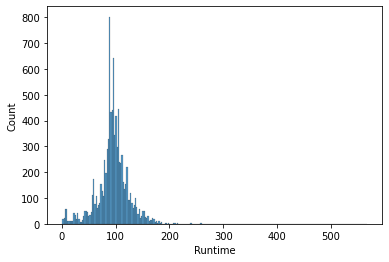

In [ ]:
# Histogram on Runtime feature
sns.histplot(data=df,x="Runtime")

In [ ]:
# LabelEncoding
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
df1['Netflix'] = enc.fit_transform(df1['Netflix'])
df1['Hulu'] = enc.fit_transform(df1['Hulu'])
df1['Prime Video'] = enc.fit_transform(df1['Prime Video'])
df1['Disney+'] = enc.fit_transform(df1['Disney+'])
df1

,Year,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Genres,Country,Language,Runtime
0,2,7.8,98,1,0,0,0,3,1,5,209.000000
1,5,8.4,97,1,0,0,0,4,6,2,161.000000
2,1,9.0,95,1,0,0,0,2,1,1,83.000000
3,20,8.1,94,1,0,0,0,3,2,2,224.000000
4,3,7.7,94,1,0,0,0,5,2,1,52.000000
...,...,...,...,...,...,...,...,...,...,...,...
9510,1,6.5,14,0,0,0,1,2,1,2,95.199435
9511,1,6.5,13,0,0,0,1,1,1,1,23.000000
9512,2,6.5,13,0,0,0,1,1,1,1,95.199435
9513,10,6.5,10,0,0,0,1,2,1,1,95.199435


In [ ]:
# Train Test Splitting
X = df1.drop("Runtime",axis=1)
y = df1["Runtime"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
display(X_train, X_test, y_train, y_test)

,Year,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Genres,Country,Language
7742,37,7.1,41,0,0,1,0,1,1,1
7615,3,6.9,42,0,0,1,0,4,1,1
7917,80,5.9,40,0,0,1,0,1,1,1
7978,85,5.2,39,0,0,1,0,5,1,1
5586,12,6.1,58,0,0,1,0,3,1,1
...,...,...,...,...,...,...,...,...,...,...
3346,4,5.4,38,1,0,0,0,1,1,1
9496,1,5.3,33,0,0,0,1,3,1,1
6321,6,4.7,51,0,0,1,0,4,3,1
8800,27,6.6,70,0,0,0,1,2,1,1


,Year,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Genres,Country,Language
2186,2,5.2,50,1,0,0,0,2,1,1
6767,8,8.5,47,0,0,1,0,1,1,1
8223,38,3.3,38,0,0,1,0,1,1,1
7382,67,3.6,43,0,0,1,0,4,1,1
2431,1,6.4,48,1,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...
8859,7,7.2,66,0,0,0,1,4,1,1
2159,0,5.1,50,1,0,0,0,2,1,1
5651,37,7.4,58,0,0,1,0,3,1,1
8678,12,7.9,81,0,0,0,1,6,2,2


7742     43.0
7615     44.0
7917     58.0
7978     83.0
5586     91.0
        ...  
3346     87.0
9496     22.0
6321    132.0
8800    108.0
7044    127.0
Name: Runtime, Length: 6660, dtype: float64

2186    170.0
6767     74.0
8223     80.0
7382      8.0
2431    102.0
        ...  
8859     76.0
2159     93.0
5651    162.0
8678     87.0
1853    150.0
Name: Runtime, Length: 2855, dtype: float64

In [ ]:
# LinearRegression model --> Our target variable is "Runtime"
from sklearn.linear_model import LinearRegression
linearReg = LinearRegression()
linearReg.fit(X_train,y_train)

LinearRegression()

In [ ]:
y_pred = linearReg.predict(X_test)

In [ ]:
print(linearReg.coef_) # Computed coefficients for each independent features
print(linearReg.intercept_) # Computed coefficients for each independent features

[ -0.0954763   -0.9900383    0.60701036   0.33912185  -4.96716019
   0.22362291 -23.46264703  -0.24512368   0.76674297   4.18826186]
66.58850096280653


In [ ]:
from sklearn.metrics import mean_squared_error
linearR2 = linearReg.score(X_test,y_test)
linearMSE = mean_squared_error(y_test,y_pred)
linearRMSE = mean_squared_error(y_test,y_pred)**0.5

### Using DecisionTree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
decTreeReg = DecisionTreeRegressor(max_depth=6)
decTreeReg.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=6)

In [ ]:
y_pred = decTreeReg.predict(X_test)

In [ ]:
decTreeR2 = decTreeReg.score(X_test,y_test)
decTreeMSE = mean_squared_error(y_test,y_pred)
decTreeRMSE = mean_squared_error(y_test,y_pred)**0.5

### Using RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
randForestReg = RandomForestRegressor()
params = {'max_depth':(1,2,3,4,5,6,7,8,9,10,100,1000),'n_estimators':(2,3,5,6,10,20,50,100,200)}
grid_search = GridSearchCV(randForestReg, params, cv=5, verbose=10)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5; 1/108] START max_depth=1, n_estimators=2...............................
[CV 1/5; 1/108] END max_depth=1, n_estimators=2;, score=0.061 total time=   0.0s
[CV 2/5; 1/108] START max_depth=1, n_estimators=2...............................
[CV 2/5; 1/108] END max_depth=1, n_estimators=2;, score=0.068 total time=   0.0s
[CV 3/5; 1/108] START max_depth=1, n_estimators=2...............................
[CV 3/5; 1/108] END max_depth=1, n_estimators=2;, score=0.078 total time=   0.0s
[CV 4/5; 1/108] START max_depth=1, n_estimators=2...............................
[CV 4/5; 1/108] END max_depth=1, n_estimators=2;, score=0.061 total time=   0.0s
[CV 5/5; 1/108] START max_depth=1, n_estimators=2...............................
[CV 5/5; 1/108] END max_depth=1, n_estimators=2;, score=0.062 total time=   0.0s
[CV 1/5; 2/108] START max_depth=1, n_estimators=3...............................
[CV 1/5; 2/108] END max_depth=1, n_estimators=

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100,
                                       1000),
                         'n_estimators': (2, 3, 5, 6, 10, 20, 50, 100, 200)},
             verbose=10)

In [ ]:
y_pred = grid_search.predict(X_test)

In [ ]:
randomForestR2 = grid_search.score(X_test,y_test)
randomForestMSE = mean_squared_error(y_test,y_pred)
randomForestRMSE = mean_squared_error(y_test,y_pred)**0.5

In [ ]:
grid_search.best_params_

{'max_depth': 9, 'n_estimators': 200}

#### Results of Regression --> Target variable is "Runtime"

In [ ]:
regDF = pd.DataFrame({"Model":["Linear Regression","Decision Tree Regressor","Random Forest with GridSearch"],
                        "R2 Score":[linearR2,decTreeR2,randomForestR2],
                        "Mean Squared Error":[linearMSE,decTreeMSE,randomForestMSE],
                        "Root Mean Squared Error":[linearRMSE,decTreeRMSE,randomForestRMSE]})
regDF

,Model,R2 Score,Mean Squared Error,Root Mean Squared Error
0,Linear Regression,0.105265,823.164504,28.690844
1,Decision Tree Regressor,0.155740,776.727318,27.869828
2,Random Forest with GridSearch,0.209160,727.580500,26.973700


### DecisionTree Model for "Netflix" as Target

In [ ]:
X = df1.drop("Netflix",axis=1)
y = df1["Netflix"]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
display(X_train, X_test, y_train, y_test)

,Year,IMDb,Rotten Tomatoes,Hulu,Prime Video,Disney+,Genres,Country,Language,Runtime
6345,10,5.3,51,0,1,0,3,1,1,93.0
4001,4,7.0,66,1,1,0,1,1,1,100.0
6556,2,5.5,49,0,1,0,3,1,1,149.0
4461,4,4.1,52,1,0,0,1,1,1,106.0
4118,8,6.4,63,1,0,0,2,1,1,88.0
...,...,...,...,...,...,...,...,...,...,...
8612,14,6.5,12,0,1,0,1,1,1,75.0
12,2,7.3,92,0,0,0,3,1,1,118.0
267,4,7.2,76,0,0,0,1,1,1,66.0
2010,4,5.4,52,0,0,0,1,1,1,83.0


,Year,IMDb,Rotten Tomatoes,Hulu,Prime Video,Disney+,Genres,Country,Language,Runtime
4064,1,6.5,64,1,0,0,4,1,1,116.0
6061,22,6.1,53,0,1,0,1,1,1,90.0
423,7,8.2,72,0,0,0,1,1,1,90.0
2531,9,5.0,47,0,0,0,2,1,1,95.0
9151,16,5.8,54,0,0,1,6,1,1,88.0
...,...,...,...,...,...,...,...,...,...,...
8624,9,8.0,88,0,0,1,3,1,3,143.0
7959,3,6.5,40,0,1,0,1,1,1,90.0
8680,23,7.6,81,0,0,1,5,3,2,115.0
6153,5,6.2,52,0,1,0,3,2,1,87.0


6345    0
4001    0
6556    0
4461    0
4118    0
       ..
8612    0
12      1
267     1
2010    1
3820    0
Name: Netflix, Length: 6660, dtype: int64

4064    0
6061    0
423     1
2531    1
9151    0
       ..
8624    0
7959    0
8680    0
6153    0
2449    1
Name: Netflix, Length: 2855, dtype: int64

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dec = DecisionTreeClassifier()
params = {'max_depth':(1,2,3,4,5,6,7,8,9,10,100,1000)}
grid_search_dec = GridSearchCV(dec, params, cv=5, verbose=10, n_jobs=-1)
grid_search_dec.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100,
                                       1000)},
             verbose=10)

In [ ]:
grid_search_dec.best_params_

{'max_depth': 3}

In [ ]:
y_pred = grid_search_dec.predict(X_test)

		Classification report for DecisionTree

               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1756
           1       1.00      0.96      0.98      1099

    accuracy                           0.99      2855
   macro avg       0.99      0.98      0.98      2855
weighted avg       0.99      0.99      0.99      2855





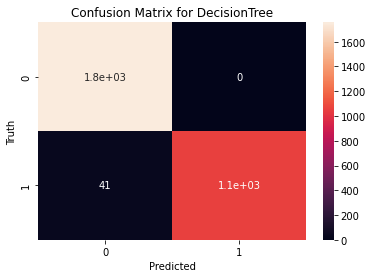

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print("\t\tClassification report for DecisionTree\n\n",classification_report(y_test,y_pred))
print()
print()
plt.title("Confusion Matrix for DecisionTree")
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True)
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.show()

## LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [ ]:
y_pred = logreg.predict(X_test)

		Classification report for LogisticRegression

               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1756
           1       1.00      0.96      0.98      1099

    accuracy                           0.99      2855
   macro avg       0.99      0.98      0.98      2855
weighted avg       0.99      0.99      0.99      2855





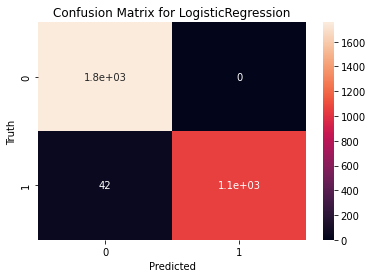

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print("\t\tClassification report for LogisticRegression\n\n",classification_report(y_test,y_pred))
print()
print()
plt.title("Confusion Matrix for LogisticRegression")
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True)
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.show()

## Support Vector Machine

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
svmachine = SVC(kernel="linear",C=1)
svmachine.fit(X_train, y_train)

SVC(C=1, kernel='linear')

In [ ]:
y_pred = svmachine.predict(X_test)

		Classification report for SVClassifier

               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1756
           1       1.00      0.96      0.98      1099

    accuracy                           0.99      2855
   macro avg       0.99      0.98      0.98      2855
weighted avg       0.99      0.99      0.99      2855





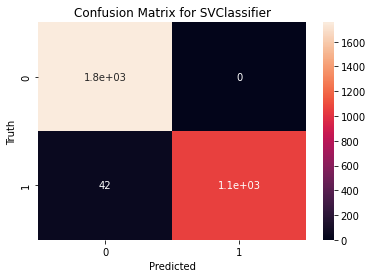

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print("\t\tClassification report for SVClassifier\n\n",classification_report(y_test,y_pred))
print()
print()
plt.title("Confusion Matrix for SVClassifier")
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True)
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.show()